# H&M Dataset EDA
*Author: Allistair Cota*

*Reviewed by Kaggle competition teammates: Andrew Dang, Pushpendra Sharma*


In this notebook, I will perform an exploratory data analysis (EDA) on the provided datasets for the [H&M Personalized Fashion Recommendations Kaggle competition](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations). The goal of the competition is to develop product recommendations based on historical transaction data and customer and product meta data associated with H&M Group. 

Based on the Kaggle data preview page, the provided files are quite large. For example, the transactions CSV file is around 3.49 GB in file size! Hence I will use PySpark/PySpark SQL predominantly over Pandas in this notebook to load in, clean, and explore the data.

**NOTE:** This is a work in progress. Check back here for regular updates. The actual predictions will be made in a separate notebook.

## Data Loading and Cleaning

PySpark is not pre-installed by default on Kaggle, hence I will use `pip` to install it.

In [1]:
!pip install pyspark

     |████████████████████████████████| 281.4 MB 29 kB/s              
  Preparing metadata (setup.py) ... - done
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=c0fff34cf8f2ff460cebd2e7844f73d01ec995c2d19b6b8c416ec7076358f71a
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
# import seaborn as sns
import plotly.express as px


from pyspark.sql import SparkSession
from pyspark.sql.functions import col,isnan, when, count

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

I will now define a new Spark session.

In [3]:
#Create SparkSession
sc = SparkSession.builder.appName('H&M').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/27 23:20:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Articles CSV File

We begin by loading in the articles CSV file, which contains the detailed metadata for each item available for purchase.

In [4]:
articles_df = sc.read.csv('/kaggle/input/h-and-m-personalized-fashion-recommendations/articles.csv', inferSchema=True, header=True)
print(f'The articles dataset has {articles_df.count()} rows and {len(articles_df.columns)} columns.')

The articles dataset has 105542 rows and 25 columns.


In [5]:
pd.DataFrame(articles_df.head(5), columns=articles_df.columns)

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [6]:
articles_df.printSchema()

root
 |-- article_id: integer (nullable = true)
 |-- product_code: integer (nullable = true)
 |-- prod_name: string (nullable = true)
 |-- product_type_no: integer (nullable = true)
 |-- product_type_name: string (nullable = true)
 |-- product_group_name: string (nullable = true)
 |-- graphical_appearance_no: integer (nullable = true)
 |-- graphical_appearance_name: string (nullable = true)
 |-- colour_group_code: integer (nullable = true)
 |-- colour_group_name: string (nullable = true)
 |-- perceived_colour_value_id: integer (nullable = true)
 |-- perceived_colour_value_name: string (nullable = true)
 |-- perceived_colour_master_id: integer (nullable = true)
 |-- perceived_colour_master_name: string (nullable = true)
 |-- department_no: integer (nullable = true)
 |-- department_name: string (nullable = true)
 |-- index_code: string (nullable = true)
 |-- index_name: string (nullable = true)
 |-- index_group_no: integer (nullable = true)
 |-- index_group_name: string (nullable = true)

The column names appear to be self-explanatory, but since an offical data dictionary has not been provided, it would be good to look at the distributions for each column to get a better idea of the type of information contained. While we could look at the histograms of all the numeric columns, the names of the numeric columns suggest that each numeric column is a label encoded version of a categorical column in the dataset (e.g. `product_type_no` and `product_type_name`, `graphical_appearance_no`, `graphical_appearance_name`). In addition all the numeric columns are of *int64* data type, suggesting they are discrete values. Hence I will look at bar plots of all the columns' value counts.

In [7]:
articles_df.createOrReplaceTempView('articles')
for column in articles_df.columns:
    unique_count = sc.sql(f"SELECT COUNT(DISTINCT {column}) FROM articles;").collect()[0][0]
    print(f'The number of unique entries in the {column} column is {"{:,}".format(unique_count)}')

The number of unique entries in the article_id column is 105,542


The number of unique entries in the product_code column is 47,224


The number of unique entries in the prod_name column is 45,875
The number of unique entries in the product_type_no column is 132
The number of unique entries in the product_type_name column is 131
The number of unique entries in the product_group_name column is 19
The number of unique entries in the graphical_appearance_no column is 30
The number of unique entries in the graphical_appearance_name column is 30
The number of unique entries in the colour_group_code column is 50
The number of unique entries in the colour_group_name column is 50
The number of unique entries in the perceived_colour_value_id column is 8
The number of unique entries in the perceived_colour_value_name column is 8
The number of unique entries in the perceived_colour_master_id column is 20
The number of unique entries in the perceived_colour_master_name column is 20
The number of unique entries in the department_no column is 299
The number of unique entries in the department_name column is 250
The number of uniqu

In [8]:
# def number_formatter(x, pos):
#     if x >= 1e6:
#         return '{:.1f}m'.format(x/1e6)
#     elif x >= 1e3:
#         return '{:.1f}k'.format(x/1e3)
#     else:
#         return x
            
        
    

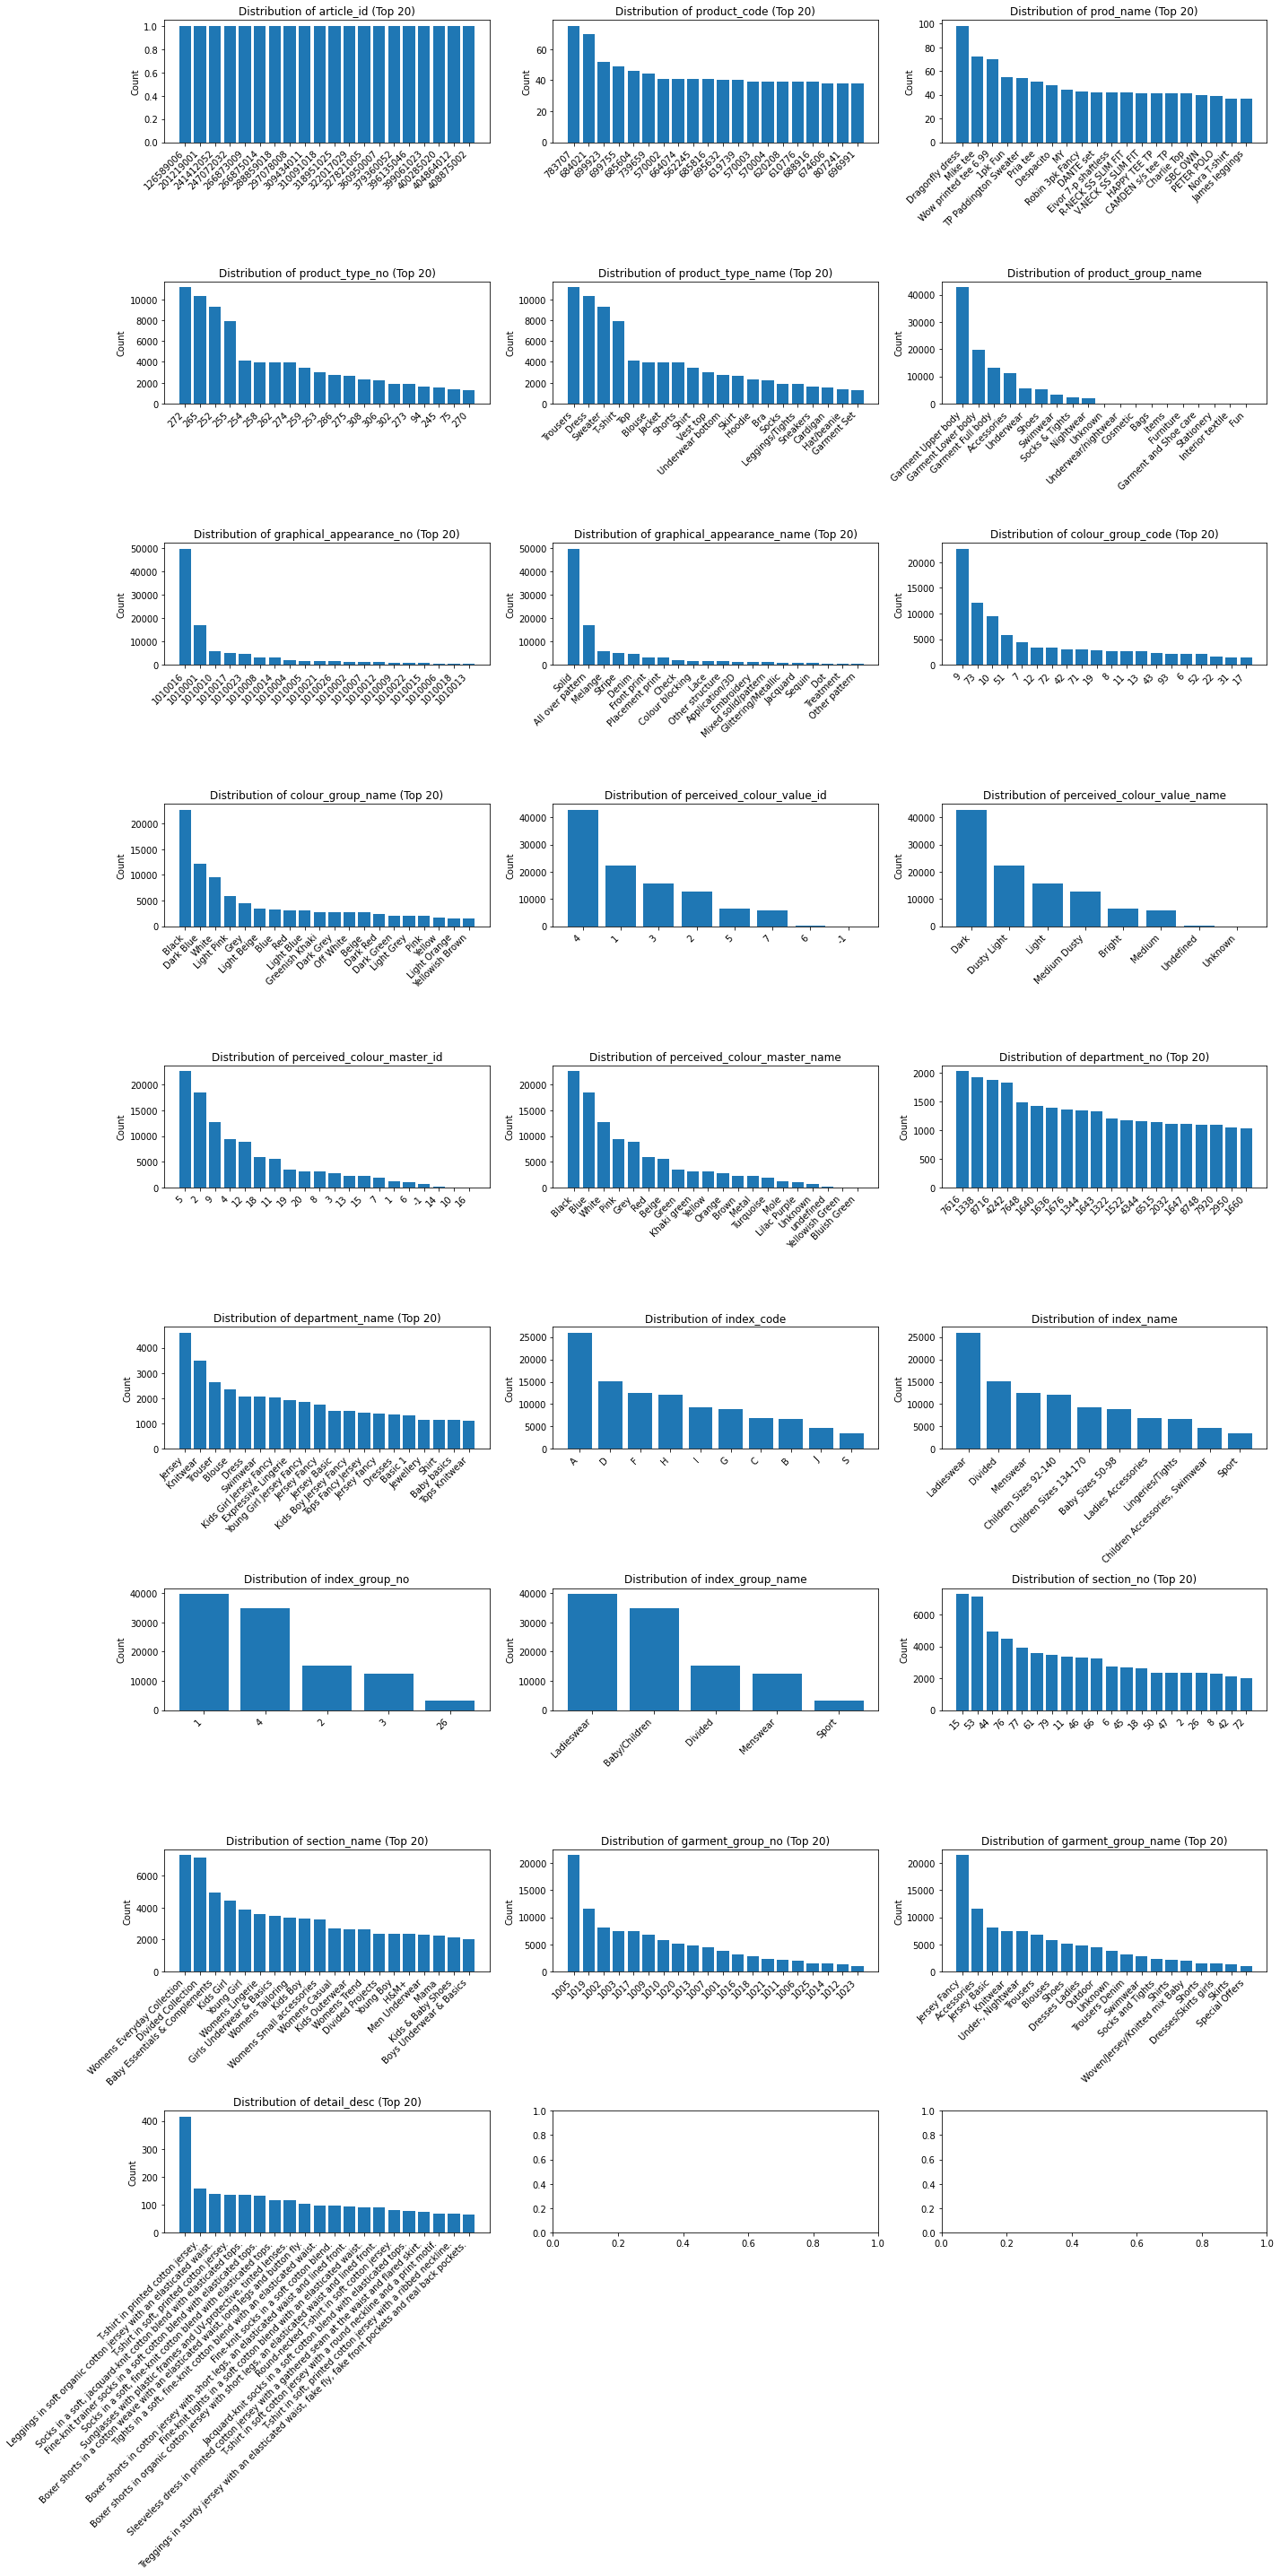

In [9]:
# Setting number of rows and columns for subplot
num_cols = len(articles_df.columns)
plot_cols = 3
plot_rows = int(np.ceil(num_cols / plot_cols))

plt.subplots(plot_rows, plot_cols, figsize=(20,40))

for i, column in enumerate(articles_df.columns, start=1):
    plt.subplot(plot_rows, plot_cols, i)
   
    # SparkSQL query
    query = sc.sql(f"SELECT {column}, COUNT(*) AS count \
                       FROM articles\
                       GROUP BY {column} \
                       ORDER BY count \
                       DESC LIMIT 40;").toPandas().set_index(column)

    # If query results greater than 20, plot only the top 20 values
    if query.shape[0] > 20:
        query = query['count'].head(20)
        plt.bar(range(20), query.values, tick_label=query.index)
        plt.title(f'Distribution of {column} (Top 20)')
        
    else:
        plt.bar(range(query.shape[0]), query['count'], tick_label=query.index)
        plt.title(f'Distribution of {column}')

    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    
plt.tight_layout()
plt.show()

It appears my guess that apart from the `article_id` and `product_code` columns, the numeric columns are numeric representations of categorical columns. There is also a noticeable discrepancy between the unique value count for the `department_no` and `department_name` columns (299 vs. 250 unique values).

In [10]:
def null_report(df, num_decimals=2):
    '''
    Reports the percentage of null or missing values in each column in a data frame.
    
    INPUTS:
    - df: PySpark dataframe to be analyzed
    - num_decimals: int data type, default value = 2. Represents the number of decimal places to display in the null value report.
    
    OUTPUT:
    - null_df: Pandas dataframe displaying the missing values in each column as a percentage of the total number rows in the dataframe.
    '''
    
    n_records = df.count()
    null_df = df.select([count(when(col(c).contains('None') | \
                                col(c).contains('NULL') | \
                                (col(c) == '' ) | \
                                col(c).isNull() | \
                                isnan(c), c 
                               )).alias(c)
                        for c in df.columns]).toPandas().T.rename( columns={0:'% Null Values'})
    null_df = (null_df/n_records*100).round(num_decimals).astype('str')+'%'
    return null_df


In [11]:
null_report(articles_df)

,% Null Values
article_id,0.0%
product_code,0.0%
prod_name,0.0%
product_type_no,0.0%
product_type_name,0.0%
product_group_name,0.0%
graphical_appearance_no,0.0%
graphical_appearance_name,0.0%
colour_group_code,0.0%
colour_group_name,0.0%


We can see that each article can has various metadata such as its product type, graphical appearance, colour group, perceived colour value, department, index, section, and garment group. The vast majority of articles have a detailed description, with the exception of 0.39% of our records.

### Customers CSV File

Let's look at the customers data frame and examine its contents.

In [12]:
customers_df = sc.read.csv('/kaggle/input/h-and-m-personalized-fashion-recommendations/customers.csv', inferSchema=True, header=True)
print(f'The articles dataset has {"{:,}".format(customers_df.count())} rows and {"{:,}".format(len(customers_df.columns))} columns.')

The articles dataset has 1,371,980 rows and 7 columns.


In [13]:
pd.DataFrame(customers_df.head(5), columns=customers_df.columns)

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [14]:
customers_df.printSchema()

root
 |-- customer_id: string (nullable = true)
 |-- FN: double (nullable = true)
 |-- Active: double (nullable = true)
 |-- club_member_status: string (nullable = true)
 |-- fashion_news_frequency: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- postal_code: string (nullable = true)



While an official data dictionary was not provided, the competition host has clarified what some of the columns refer to in the comments to the [introductory post](https://www.kaggle.com/c/h-and-m-personalized-fashion-recommendations/discussion/305952).

Hence the columns are as follows:

- `customer_id`: string object, the primary key for the customers data frame.
- `FN`: float, indicating if the customer receives a Fashion News newsletter. This could probably be a binary integer column.
- `Active`: float, indicating if the customer is active for communication. This could probably be a binary integer column.
- `club_member_status`: string object, indicating the customer's club membership status.
- `fashion_news_frequency`: string object, indicating the frequency at which the customer receives a Fashion News newsletter.
- `age`: float, the age of the customer.
- `postal_code`: string object, the postal code of the customer's address.

It appears there are many missing values from the dataset. I will look at the percentage of missing values from each column.

In [15]:
null_report(customers_df)

,% Null Values
customer_id,0.0%
FN,65.24%
Active,66.15%
club_member_status,0.44%
fashion_news_frequency,1.17%
age,1.16%
postal_code,0.0%


There are many missing values from the `FN` and `Active` columns. We are also missing some values regarding club member status, Fashion News frequency, and age.

Let's look at the value counts for the `Active` column.

In [16]:
customers_df.createOrReplaceTempView('customers')

sc.sql("SELECT Active, COUNT(*) AS count \
       FROM customers\
       GROUP BY Active \
       ORDER BY count \
       DESC LIMIT 40;").toPandas()

,Active,count
0,NaN,907576
1,1.0,464404


The majority of values in this column are null values, while the rest are of value = 1 which indicates that the customer is active for communication. While we cannot verify this for sure, I will assume the null values correspond to customers who are not active for communication, and will replace this values with 0 to binarize the column.

In [17]:
customers_df = customers_df.fillna(0, subset=['Active'])

In [18]:
customers_df.createOrReplaceTempView('customers')

sc.sql("SELECT Active, COUNT(*) AS count \
       FROM customers\
       GROUP BY Active \
       ORDER BY count \
       DESC LIMIT 40;").toPandas()

,Active,count
0,0.0,907576
1,1.0,464404


I might be able to impute missing values of the `FN` column based on information in the `fashion_news_frequency` column.

In [19]:
sc.sql("SELECT FN, fashion_news_frequency, COUNT(*) AS count \
       FROM customers\
       GROUP BY FN, fashion_news_frequency \
       ORDER BY count \
       DESC LIMIT 40;").toPandas()

,FN,fashion_news_frequency,count
0,NaN,NONE,876922
1,1.0,Regularly,475310
2,NaN,None,16009
3,NaN,Regularly,2106
4,1.0,Monthly,829
5,1.0,NONE,789
6,NaN,Monthly,13
7,1.0,None,2


There are missing `FN` values for customers that have a 'Monthly' or 'Regularly' frequency for receiving Fashion News. I will infer that these customers are in fact receiving Fashion News, and set these values to 1. Similarly, those that have 'None' as their Fashion News frequency should have an `FN` value of 0, since they do not receive a newsletter.

In [20]:
customers_df = customers_df.fillna('NONE', subset=['fashion_news_frequency'])

customers_df = customers_df.withColumn('fashion_news_frequency', when(customers_df['fashion_news_frequency'].contains('None'), 'NONE').otherwise(customers_df['fashion_news_frequency']))

customers_df = customers_df.withColumn('FN', when((customers_df['fashion_news_frequency'] == 'Regularly') | \
                                                  (customers_df['fashion_news_frequency'] == 'Monthly'), 1).otherwise(customers_df['FN']))

customers_df = customers_df.withColumn('FN', when((customers_df['fashion_news_frequency'] == 'NONE') | \
                                                  (customers_df['fashion_news_frequency'] == 'None'), 0).otherwise(customers_df['FN']))

In [21]:
customers_df.createOrReplaceTempView('customers')

sc.sql("SELECT FN, fashion_news_frequency, COUNT(*) AS count \
       FROM customers\
       GROUP BY FN, fashion_news_frequency \
       ORDER BY count \
       DESC LIMIT 40;").toPandas()

,FN,fashion_news_frequency,count
0,0.0,NONE,893722
1,1.0,Regularly,477416
2,1.0,Monthly,842


Let's take a look at the remaining missing values in the data frame.

In [22]:
null_report(customers_df)

,% Null Values
customer_id,0.0%
FN,0.0%
Active,0.0%
club_member_status,0.44%
fashion_news_frequency,0.0%
age,1.16%
postal_code,0.0%


To impute the missing values of the `age` column, I will look at its distribution.

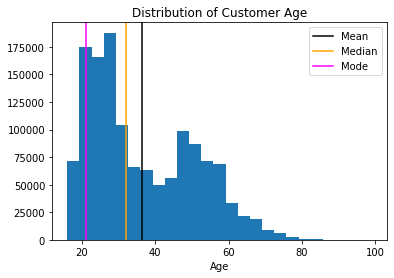

In [23]:
customers_df.createOrReplaceTempView('customers')


query = sc.sql('SELECT age FROM customers;').toPandas().squeeze()

plt.figure()
plt.hist(query, bins=25)
plt.axvline(query.mean(), label='Mean', color='black')
plt.axvline(query.median(), label='Median', color='orange')
plt.axvline(query.mode()[0], label='Mode', color='magenta')
plt.legend()

plt.xlabel('Age')
plt.title('Distribution of Customer Age')
plt.show()

The distribution appears to be somewhat bimodal with a right-skewness. The mean, median, and mode are typical candidates for imputation, but in this case the mean does not appear appropriate as the bimodal distribution centers the mean between the two peaks. The mode appears to be in the heaviest part of the distribution, hence I will impute with the mode value.

In [24]:
mode = query.mode()[0]
customers_df = customers_df.fillna(mode, subset=['age'])

In [25]:
null_report(customers_df)

,% Null Values
customer_id,0.0%
FN,0.0%
Active,0.0%
club_member_status,0.44%
fashion_news_frequency,0.0%
age,0.0%
postal_code,0.0%


The final column with missing values is the `club_member_status` column. Let's look at its value counts.

In [26]:
customers_df.createOrReplaceTempView('customers')

sc.sql('SELECT club_member_status, ROUND(COUNT(*) * 100 /SUM(COUNT(*)) OVER(), 2) AS percent \
        FROM customers \
        GROUP BY club_member_status \
        ORDER BY percent DESC;').toPandas()

22/04/27 23:22:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/27 23:22:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/27 23:22:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


,club_member_status,percent
0,ACTIVE,92.75
1,PRE-CREATE,6.78
2,None,0.44
3,LEFT CLUB,0.03


This is a categorical column. Since we do not have any other columns to infer member status, I will choose to impute the missing values with the mode value, which is the 'ACTIVE' status.

In [27]:
customers_df = customers_df.fillna('ACTIVE', subset=['club_member_status'])

In [28]:
null_report(customers_df)

,% Null Values
customer_id,0.0%
FN,0.0%
Active,0.0%
club_member_status,0.0%
fashion_news_frequency,0.0%
age,0.0%
postal_code,0.0%


The customers data frame no longer contains any missing values.

### Transactions CSV File

I will now load in the transactions CSV file.

In [29]:
transactions_df = sc.read.csv('/kaggle/input/h-and-m-personalized-fashion-recommendations/transactions_train.csv', inferSchema=True, header=True)
print(f'The articles dataset has {"{:,}".format(transactions_df.count())} rows and {"{:,}".format(len(transactions_df.columns))} columns.')

The articles dataset has 31,788,324 rows and 5 columns.


In [30]:
pd.DataFrame(transactions_df.head(5), columns=transactions_df.columns)

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


In [31]:
transactions_df.printSchema()

root
 |-- t_dat: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- article_id: integer (nullable = true)
 |-- price: double (nullable = true)
 |-- sales_channel_id: integer (nullable = true)



The data dictionary for this data frame is as floows:
- `t_dat`: string object, date of the trasaction.
- `customer_id`: string object, foreign key to the customers data frame.
- `article_id`: integer, foreign key to the articles data frame.
- `price`: float, scaled price of the item. According to the [competition host](https://www.kaggle.com/c/h-and-m-personalized-fashion-recommendations/discussion/306016), the data has been scaled for privacy reasons and the currency is not specified.
- `sales_channel_id`: integer, representing the sales channel. 1 represents a store purchase, 2 represents an online purchase.

According the [data description](https://www.kaggle.com/c/h-and-m-personalized-fashion-recommendations/data) on the competition page duplicate rows correspond to multiple purchases of the same item.

In [32]:
null_report(transactions_df)

,% Null Values
t_dat,0.0%
customer_id,0.0%
article_id,0.0%
price,0.0%
sales_channel_id,0.0%


There are no missing values in the transactions data frame.

## Exploratory Data Analysis (EDA)

I will now proceed to explore the data using PySpark SQL. The broad questions that i would like to explore are as follows:
* How have the transactions varied over time and across the different sales channels?
* What are the most popular product types, colour groups, departments, index groups and sections?
* What are the most popular items per season?
* What is the distribution of customer age groups based on number of transactions?
* What is the relationship between number of transactions and active / fashion news frequency and club member status?
* Which departments / sections have the highest average item price?

In [33]:
articles_df.createOrReplaceTempView('articles')
customers_df.createOrReplaceTempView('customers')
transactions_df.createOrReplaceTempView('transactions')


#### Transaction Variation Over Time and Sales Channels

**What is the time span of transaction data?**

In [34]:
sc.sql('SELECT MIN(t_dat) AS first_date, MAX(t_dat) AS last_date FROM transactions;').toPandas()

,first_date,last_date
0,2018-09-20,2020-09-22


The transaction data spans from the September 20 2018 to September 22 2020. Let us look at the variation in number of daily transactions

In [35]:
query = sc.sql('SELECT t_dat AS Date, COUNT(*) AS num_purchases \
                FROM transactions \
                GROUP BY Date \
                ORDER BY Date;').toPandas()

fig = px.line(query, x='Date', y='num_purchases')

fig.update_layout(
    yaxis_title="Number of Transactions", 
    title="Transactions Over Time"
)

# activate slider
fig.update_xaxes(rangeslider_visible=True)

fig.show()

From the plot above, there doesn't appear to be any underlying trend regarding the number of transactions over time. There does appear to be some seasonality as indicated by the peaks in April and the last week of September for both 2019 and 2020, as well as the lows during the last week of December for both 2018 and 2019 (after Christmas Day).

**Which sales channel produces the most transactions?**

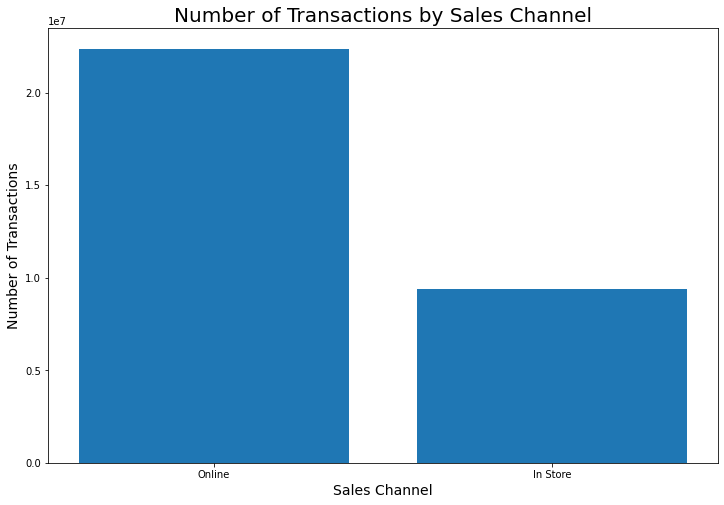

In [36]:
query = sc.sql('SELECT \
                   (CASE \
                       WHEN sales_channel_id = 1 THEN "In Store" \
                       ELSE "Online" \
                   END) AS sales_channel, COUNT(*) AS num_purchases \
               FROM transactions \
               GROUP BY sales_channel \
               ORDER BY num_purchases \
               DESC LIMIT 20;').toPandas()

plt.figure(figsize=(12,8))
plt.bar(query['sales_channel'], query['num_purchases'])
plt.title('Number of Transactions by Sales Channel', fontsize=20)
plt.xlabel('Sales Channel', fontsize=14)
plt.ylabel('Number of Transactions', fontsize=14)
plt.show()


We can see that online transactions greatly outnumber in store transactions. Hence it will be worth looking how the number of transactions vary over time across the different sales channels.

In [37]:
%%time

query = sc.sql('SELECT t_dat AS Date, SUM(IF(sales_channel_id=1, 1, 0)) AS in_store, SUM(IF(sales_channel_id=2, 1, 0)) AS online \
                FROM transactions \
                GROUP BY Date \
                ORDER BY Date;').toPandas().set_index('Date')

# add lines for each column
fig = px.line(query, x=query.index, y=query.columns)

# axis labels and title
fig.update_layout(
    yaxis_title="Number of Transactions", 
    legend_title="", 
    title="Transactions Over Time"
)

# activate slider
fig.update_xaxes(rangeslider_visible=True)

fig.show()

CPU times: user 120 ms, sys: 11.3 ms, total: 132 ms
Wall time: 24.1 s


We can see from the plot above that there were no transactions made in store from March 20, 2020 to May 3, 2020, likely as a result of retail space closures due to the COVID-19 pandemic. During that same time period, the number of online transactions increased, which might be the result of in store shoppers being forced to make their purchases online due to the pandemic. The spikes that were observed in the previous transactions over time chart are predominantly online purchases. This spikes might be related to special sales or promotions made available on the online store.



#### Most popular product types, colour groups, departments, index groups, and sections

I will now look at the most popular occurances for the following categories based on number of transactions, and I will also look for any differences between online and in store transactions.
- product type name
- colour group name
- department name
- index group name
- section name

In [38]:
column_list = ['product_type_name', 'colour_group_name', 'department_name', 'index_group_name', 'section_name']
column_list

['product_type_name',
 'colour_group_name',
 'department_name',
 'index_group_name',
 'section_name']

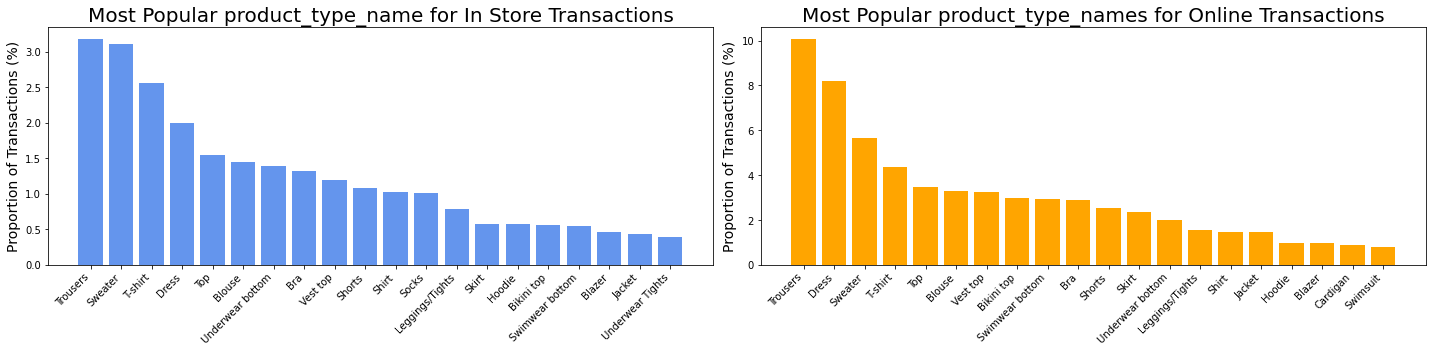

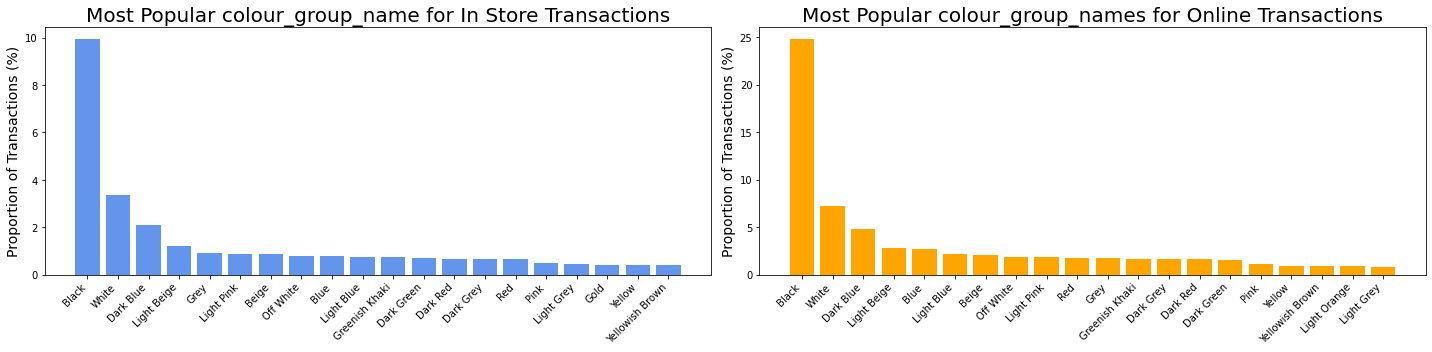

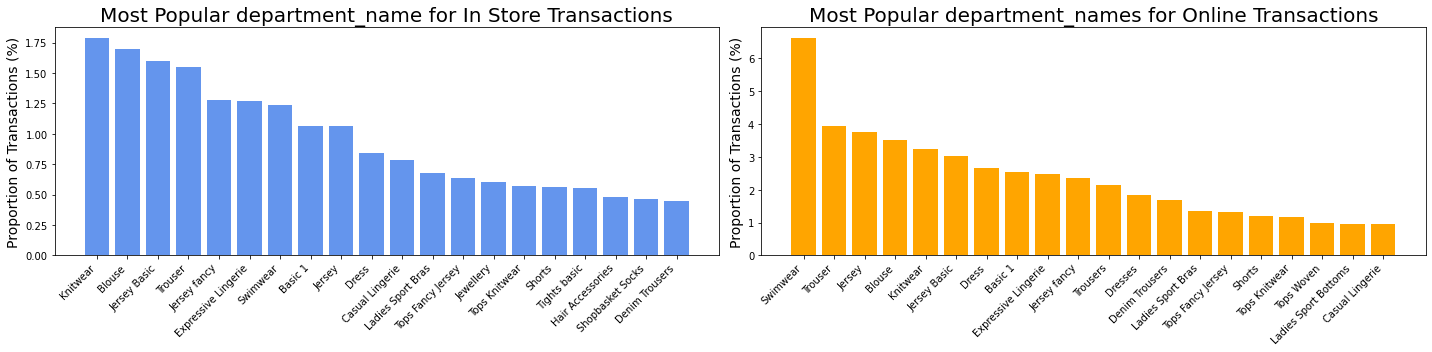

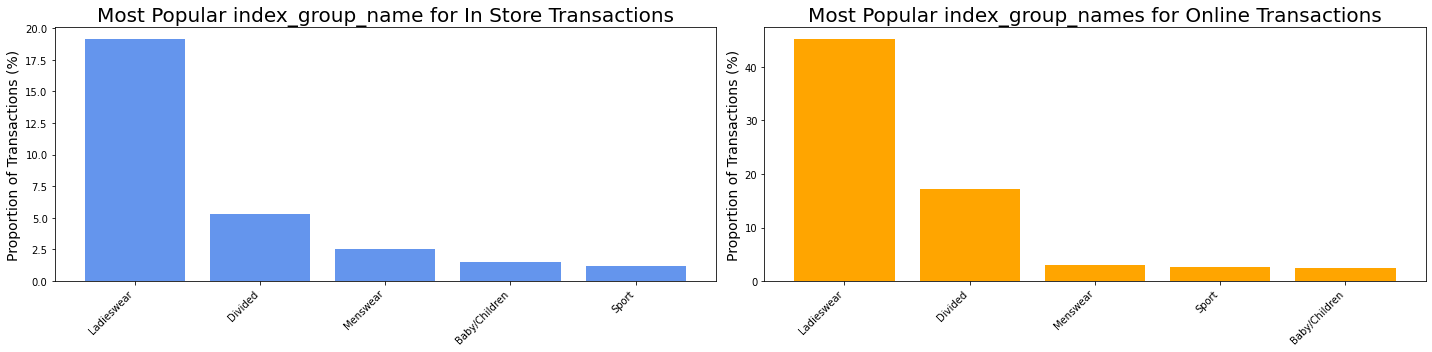

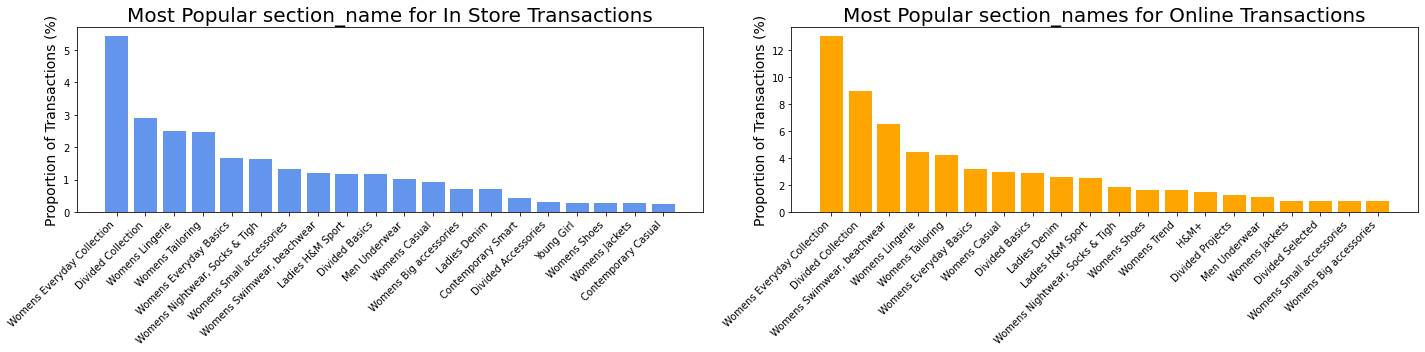

CPU times: user 3.91 s, sys: 1.21 s, total: 5.12 s
Wall time: 5min 11s


In [39]:
%%time

# Setting number of rows and columns for subplot
num_cols = len(column_list)
plot_cols = 2
plot_rows = num_cols

#plt.subplots(plot_rows, plot_cols, figsize=(20,35))

i = 1
for column in column_list:
    plt.subplots(1, 2, figsize=(20,5))
   
    # SparkSQL query
    query = sc.sql(f'SELECT articles.{column} AS {column}, \
                     COUNT(transactions.article_id)/(SELECT COUNT(*) FROM transactions)*100 AS percent \
                     FROM transactions LEFT JOIN articles \
                     ON transactions.article_id = articles.article_id \
                     WHERE transactions.sales_channel_id = 1 \
                     GROUP BY articles.{column} \
                     ORDER BY percent DESC \
                     LIMIT 20;').toPandas().set_index(column).squeeze()
    
    plt.subplot(1, 2, 1)
    plt.bar(range(query.shape[0]), query.values, tick_label=query.index, color='cornflowerblue')
    plt.title(f'Most Popular {column} for In Store Transactions', fontsize=20)
    plt.ylabel('Proportion of Transactions (%)', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    
    i += 1
    
    #plt.subplot(plot_rows, plot_cols, i)
   
    # SparkSQL query
    query = sc.sql(f'SELECT articles.{column} AS {column}, \
                     COUNT(transactions.article_id)/(SELECT COUNT(*) FROM transactions)*100 AS percent \
                     FROM transactions LEFT JOIN articles \
                     ON transactions.article_id = articles.article_id \
                     WHERE transactions.sales_channel_id = 2 \
                     GROUP BY articles.{column} \
                     ORDER BY percent DESC \
                     LIMIT 20;').toPandas().set_index(column).squeeze()
    
    plt.subplot(1, 2, 2)
    plt.bar(range(query.shape[0]), query.values, tick_label=query.index, color='orange')
    plt.title(f'Most Popular {column}s for Online Transactions', fontsize=20)
    plt.ylabel('Proportion of Transactions (%)', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    i += 1
    
# plt.tight_layout()
# plt.show()

- Product type name:
  - It appears that dresses and swimwear items are more likely to be bought online than in-store.
 
 
- Colour group name:
  - Grey and other grey shades like light grey and dark grey are more likely to be bought in-store than online. Brighter colours appear to be bought more frequently online than in-store.
 
 
- Department name:
  - Swimwear is more popular among online transactions than knitwear, and the opposite is true for in store transactions.
 
 
- Index group name:
  - Baby & children items are more popular than sport items for in-store transactions, and the opposite is true for online transactions.
 
 
- Section name:
  - Once again, swimwear appears to be more popular than women's tailoring among online purchases than in-store purchases.

From the observations above, a common theme was that swimwear items and brighter coloured item, which one might associate as more popular during summer months, are more likely to be bought online than in-store, whereas knitwear / tailoring items and darker coloured items, which one might associate as more popular during colder months, are more likely to be bought in-store than online. I will now investigate whether there is any relationship between season and popularity of items.

**Most Popular Items per Season**

I will examine the most popular departments, sections, and colour groups per season based on total number of purchases across all channels. In a fashion context, definitions of seasons can vary per region. For the purpose of this study, we will use the common seasonal breakdown shared by northern hemisphere countries like the US, UK, and China as defined by this [source](https://www.textiletoday.com.bd/understanding-retail-seasons-fashion-trends/).

In [40]:
seasons = {'Spring': ((3, 5), ('limegreen','forestgreen')),
           'Summer': ((6, 8), ('khaki', 'darkkhaki')),
           'Fall': ((9, 11), ('orange', 'peru')),
           'Winter': ((12, 2), ('cornflowerblue', 'mediumblue'))}

In [41]:
def plot_by_season(col, seasons, figsize=(20,5)):
    plt.subplots(1, 4, figsize=figsize)

    i = 1
    for season in seasons.keys():
        if season == 'Winter':
            statement = f'MONTH(t_dat)={seasons[season][0][0]} OR MONTH(t_dat) BETWEEN {seasons[season][0][1]-1} AND {seasons[season][0][1]}'
        else:
            statement = f'MONTH(t_dat) BETWEEN {seasons[season][0][0]} AND {seasons[season][0][1]}'

        query = sc.sql(f"SELECT articles.{col}, \
                                SUM(a.in_store_purchases) AS in_store_purchases, \
                                SUM(a.online_purchases) AS online_purchases, \
                                SUM(a.num_purchases) AS num_purchases \
                         FROM ( \
                               SELECT article_id, \
                                      SUM(IF(sales_channel_id=1,1,0)) AS in_store_purchases, \
                                      SUM(IF(sales_channel_id=2,1,0)) AS online_purchases, \
                                      COUNT(*) AS num_purchases \
                               FROM transactions \
                               WHERE {statement} \
                               GROUP BY article_id) a \
                         LEFT JOIN articles ON \
                             articles.article_id = a.article_id \
                         GROUP BY articles.{col} \
                         ORDER BY num_purchases DESC \
                         LIMIT 5;").toPandas().sort_values(by='num_purchases')

        plt.subplot(1, 4, i)   
        plt.barh(query[col], query['online_purchases'], label='Online', color=seasons[season][1][0])
        plt.barh(query[col], query['in_store_purchases'], label='In Store', left=query['online_purchases'], color=seasons[season][1][1])
        plt.title(f'Most popular {col}s for {season}')
        plt.xlabel('Number of Transactions')
        plt.legend()
        i += 1

    plt.tight_layout()
    plt.show()
    

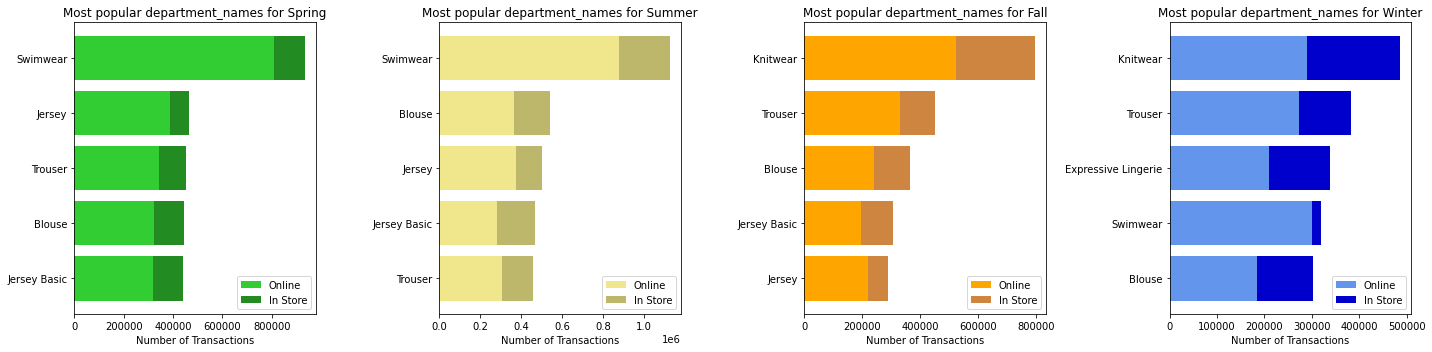

CPU times: user 1.13 s, sys: 278 ms, total: 1.41 s
Wall time: 2min 5s


In [42]:
%%time
plot_by_season('department_name', seasons)

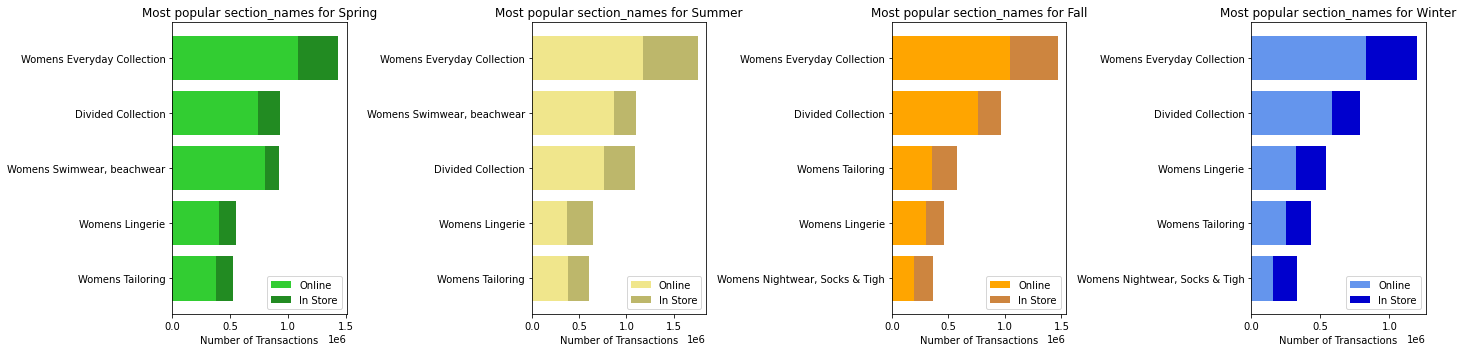

CPU times: user 1.11 s, sys: 268 ms, total: 1.38 s
Wall time: 2min 1s


In [43]:
%%time
plot_by_season('section_name', seasons)

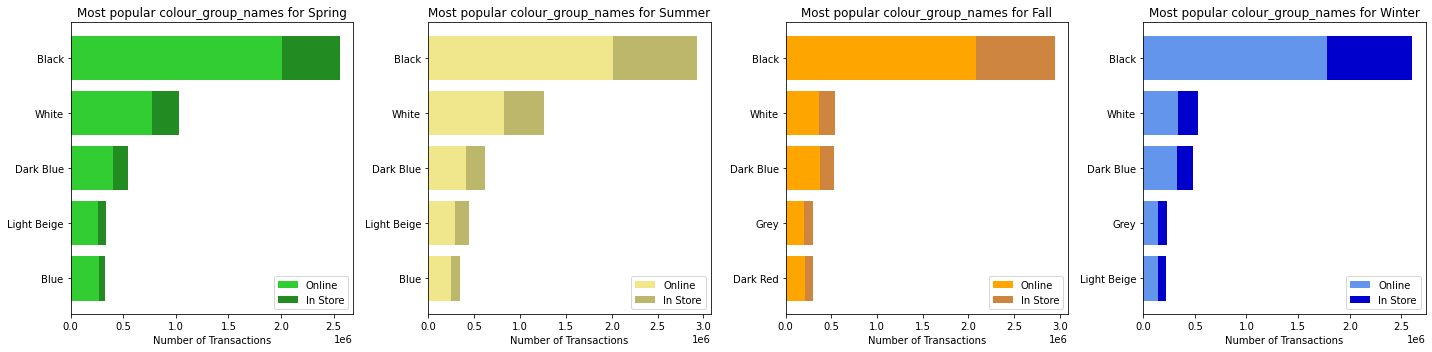

CPU times: user 1.06 s, sys: 276 ms, total: 1.34 s
Wall time: 1min 58s


In [44]:
%%time
plot_by_season('colour_group_name', seasons)

**Top Performing Departments by Season Based on Revenue**

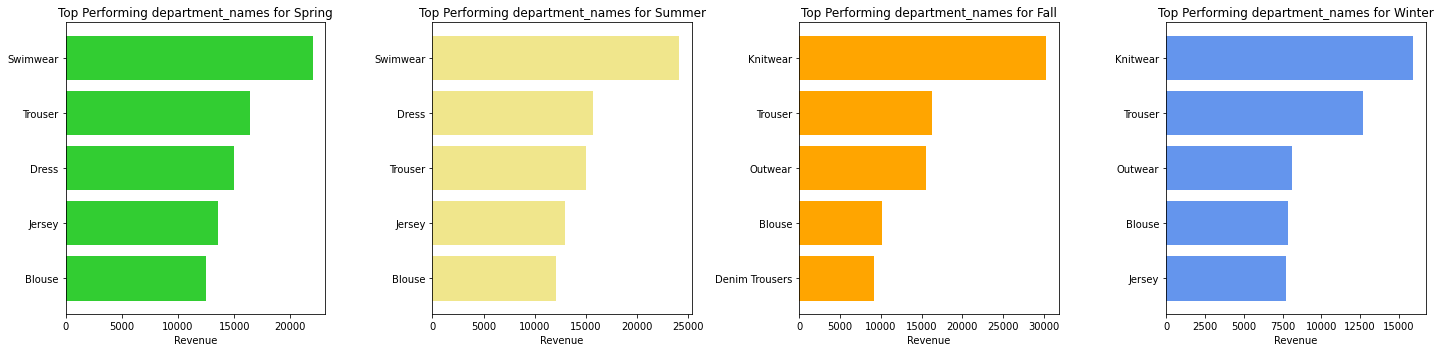

In [45]:
col='department_name'
figsize=(20,5)

plt.subplots(1, 4, figsize=figsize)

i = 1
for season in seasons.keys():
    if season == 'Winter':
        statement = f'MONTH(t_dat)={seasons[season][0][0]} OR MONTH(t_dat) BETWEEN {seasons[season][0][1]-1} AND {seasons[season][0][1]}'
    else:
        statement = f'MONTH(t_dat) BETWEEN {seasons[season][0][0]} AND {seasons[season][0][1]}'

    query = sc.sql(f"SELECT articles.{col}, SUM(a.revenue) AS revenue \
                     FROM (\
                       SELECT article_id, SUM(price) AS revenue \
                       FROM transactions \
                       WHERE {statement} \
                       GROUP BY article_id) a \
                     LEFT JOIN articles ON \
                         a.article_id = articles.article_id \
                     GROUP BY articles.{col} \
                     ORDER BY revenue DESC \
                     LIMIT 5;").toPandas().sort_values(by='revenue')

    plt.subplot(1, 4, i)
    plt.barh(query[col], query['revenue'], color=seasons[season][1][0])
    plt.title(f'Top Performing {col}s for {season}')
    plt.xlabel('Revenue')
    i += 1

plt.tight_layout()
plt.show()

**Customer Loyalty based on Age**

In [46]:
query = sc.sql('SELECT transactions.sales_channel_id, customers.age AS age, COUNT(transactions.customer_id) AS num_purchases \
        FROM transactions \
        LEFT JOIN customers \
        ON transactions.customer_id = customers.customer_id \
        GROUP BY transactions.sales_channel_id, customers.age \
        ORDER BY num_purchases').toPandas()

22/04/27 23:42:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/27 23:42:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/27 23:42:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/27 23:42:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/27 23:42:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/27 23:42:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/27 23:42:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/27 23:42:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/27 23:42:23 WARN RowBasedKeyValueBatch: Calling spill() on

#### Customer Age Distribution

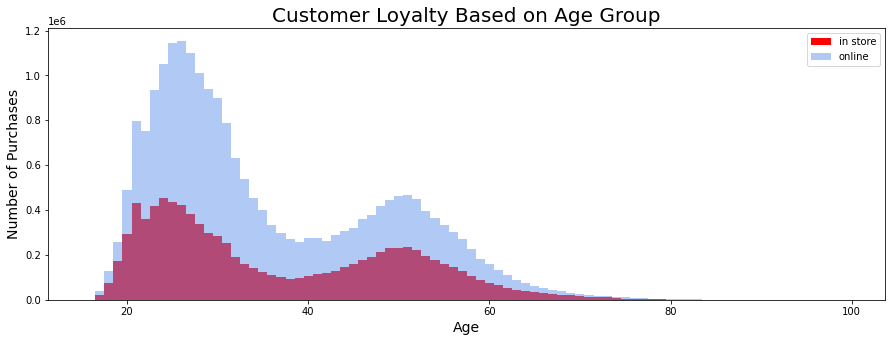

In [47]:
plt.figure(figsize=(15,5))
plt.bar(query.loc[query['sales_channel_id']==1,'age'], query.loc[query['sales_channel_id']==1,'num_purchases'], width=1, color='red', label='in store')
plt.bar(query.loc[query['sales_channel_id']==2,'age'], query.loc[query['sales_channel_id']==2,'num_purchases'], width=1, color='cornflowerblue', label='online', alpha=0.5)
plt.title('Customer Loyalty Based on Age Group', fontsize=20)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Number of Purchases', fontsize=14)
plt.legend()
plt.show()

#### Distribution of Active / Fashion News Frequency / Club Member Status

22/04/27 23:43:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/27 23:43:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/27 23:43:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/27 23:43:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/27 23:43:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/27 23:43:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/27 23:43:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/27 23:43:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/27 23:43:23 WARN RowBasedKeyValueBatch: Calling spill() on

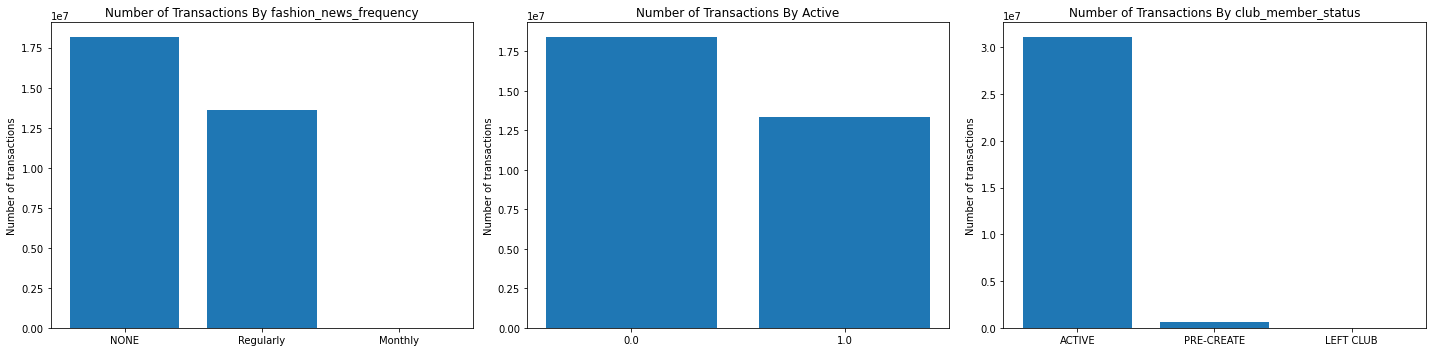

In [48]:
column_list = ['fashion_news_frequency', 'Active', 'club_member_status']

plt.subplots(1, 3, figsize=(20,5))

for i, col in enumerate(column_list, start=1):

    query = sc.sql(f'SELECT customers.{col}, COUNT(*) AS num_purchases \
                    FROM transactions \
                    LEFT JOIN customers \
                    ON customers.customer_id = transactions.customer_id \
                    GROUP BY customers.{col} \
                    ORDER BY num_purchases DESC LIMIT 10').toPandas()
    
    plt.subplot(1, 3, i)
    plt.bar(query[col].astype('str'), query['num_purchases'])
    plt.title(f'Number of Transactions By {col}')
    plt.ylabel('Number of transactions')
    

plt.tight_layout()
plt.show()

#### Highest Average Item Price

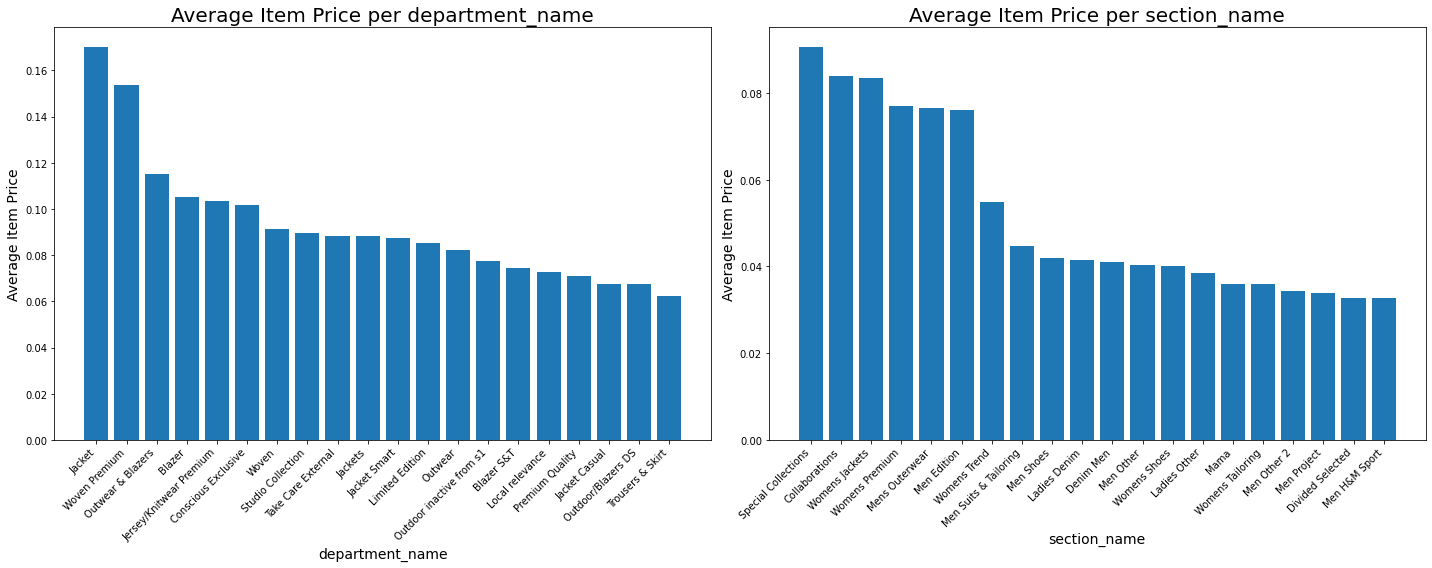

In [49]:
plt.subplots(1, 2, figsize=(20,8))

column_list = ['department_name', 'section_name']

for i, col in enumerate(column_list, start=1):
    
    query = sc.sql(f"SELECT articles.{col}, \
                     AVG(transactions.price) AS price \
                     FROM transactions \
                     LEFT JOIN articles ON \
                         transactions.article_id = articles.article_id \
                     GROUP BY articles.{col} \
                     ORDER BY price DESC \
                     LIMIT 20;").toPandas()
    
    plt.subplot(1, 2, i)
    plt.bar(query[col], query['price'])
    plt.title(f'Average Item Price per {col}', fontsize=20)
    plt.xlabel(col, fontsize=14)
    plt.ylabel('Average Item Price', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    
plt.tight_layout()
plt.show()
    

***To be continued...***